In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [4]:
datadir = '/cellar/users/snwright/Data/RareCommon/'
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/Figure1/'

# GCat Only

In [5]:
gcat_meta = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features.tsv'), sep='\t')
gcat_meta = gcat_meta.rename(columns={'ClassificationFinal':'trait_type', 'DISEASE/TRAIT':'Trait'})

In [6]:
gcat_meta.shape

(261, 7)

<Axes: >

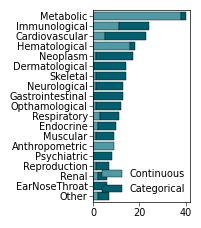

In [7]:
domains = gcat_meta.Domain.value_counts()
domains_plot = domains[domains>=5].index.values

q_counts = gcat_meta[(gcat_meta.trait_type=='Q') & gcat_meta.Domain.isin(domains_plot)].Domain.value_counts().to_dict()
cc_counts = gcat_meta[(gcat_meta.trait_type=='CC') & gcat_meta.Domain.isin(domains_plot)].Domain.value_counts().to_dict()
q_other = gcat_meta[(gcat_meta.trait_type=='Q') & ~gcat_meta.Domain.isin(domains_plot)].Domain.value_counts().sum()
cc_other = gcat_meta[(gcat_meta.trait_type=='CC') & ~gcat_meta.Domain.isin(domains_plot)].Domain.value_counts().sum()
q_counts['Other'] = q_other
cc_counts['Other'] = cc_other
plot_df = pd.DataFrame({'Continuous': q_counts, 'Categorical': cc_counts}).iloc[::-1].fillna(0)
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum', ascending=False)
_ = plt.figure(figsize=(1.25, 2.5))
plot_df.drop(columns=['sum']).iloc[::-1].plot(kind='barh', stacked=True, ax=plt.gca(),
                                                                              edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
#plt.savefig(os.path.join(figdir, 'disease_distribution_barplot_gcat.svg'), bbox_inches='tight')

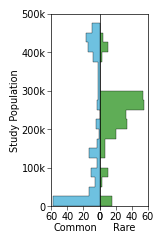

In [19]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.25, 2.5), sharey=True, gridspec_kw={'wspace':0})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= gcat_meta.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= gcat_meta.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(60, 0)
ax2.set_xlim(0, 60)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([60, 40, 20, 0])
ax2.set_xticks([0, 20,40, 60])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)
plt.savefig(os.path.join(figdir, 'population_size_histograms_gcat.svg'), bbox_inches='tight')

# Combined UKB and GCat

In [4]:
ukb_meta = pd.read_csv(os.path.join(datadir, 'inputs/UKB/input_figure_metadata.tsv'), sep='\t')
gcat_meta = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_no_ukb.tsv'), sep='\t')
gcat_meta = gcat_meta.rename(columns={'ClassificationFinal':'trait_type', 'DISEASE/TRAIT':'Trait'})

In [5]:
all_meta = pd.concat([ukb_meta, gcat_meta])

In [6]:
all_meta['Domain'] = all_meta.Domain.apply(lambda z: z if z != 'Neoplasm' else 'Neoplasms')

### Trait distribution

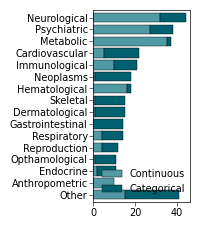

In [7]:
domains = all_meta.Domain.value_counts()
domains_plot = domains[domains>=10].index.values

q_counts = all_meta[(all_meta.trait_type=='Q') & all_meta.Domain.isin(domains_plot)].Domain.value_counts().to_dict()
cc_counts = all_meta[(all_meta.trait_type=='CC') & all_meta.Domain.isin(domains_plot)].Domain.value_counts().to_dict()
q_other = all_meta[(all_meta.trait_type=='Q') & ~all_meta.Domain.isin(domains_plot)].Domain.value_counts().sum()
cc_other = all_meta[(all_meta.trait_type=='CC') & ~all_meta.Domain.isin(domains_plot)].Domain.value_counts().sum()
q_counts['Other'] = q_other
cc_counts['Other'] = cc_other
plot_df = pd.DataFrame({'Continuous': q_counts, 'Categorical': cc_counts}).iloc[::-1].fillna(0)
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum', ascending=False)
_ = plt.figure(figsize=(1.25, 2.5))
plot_df.drop(columns=['sum']).iloc[::-1].plot(kind='barh', stacked=True, ax=plt.gca(),
                                                                              edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.savefig(os.path.join(figdir, 'disease_distribution_barplot_combined.svg'), bbox_inches='tight')

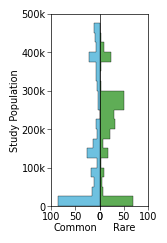

In [8]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.25, 2.5), sharey=True, gridspec_kw={'wspace':0})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= all_meta.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= all_meta.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(100, 0)
ax2.set_xlim(0, 100)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([100, 50, 0])
ax2.set_xticks([0, 50, 100])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)
plt.savefig(os.path.join(figdir, 'population_size_histograms_combined.svg'), bbox_inches='tight')